In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
philosopher0808_real_vs_ai_generated_faces_dataset_path = kagglehub.dataset_download('philosopher0808/real-vs-ai-generated-faces-dataset')

print('Data source import complete.')


Data source import complete.


In [ ]:

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import  cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import load_model

In [ ]:
data_dir = '/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset'

In [ ]:
os.listdir(data_dir)

['validate', 'test', 'train']

In [ ]:
print(len( os.listdir((os.path.join(data_dir,'train','0')))))
print(len( os.listdir((os.path.join(data_dir,'train','1')))))

42000
30574


In [ ]:
class DataGenerator():
    def __init__(self, batch_size, target_size=(256, 256)):
        self.batch_size = batch_size
        self.target_size = target_size

    def generate_data(self, subset, directory):

        print("Loading", subset, "...")

        shuffle = False
        if subset == 'train' or subset == 'validation':
            shuffle = True

        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            class_names=['0', '1'],
            color_mode='rgb',
            batch_size=self.batch_size,
            image_size=self.target_size,
            shuffle=shuffle,
            seed=42,
        )

        return dataset

In [ ]:
def augmentation_layer(dataset):
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomBrightness(0.2),
        ]
    )
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    return dataset # Return the augmented dataset

In [ ]:
batch_size = 256
target_size = (256, 256)
data_gen = DataGenerator(batch_size, target_size)

train_set = data_gen.generate_data('train', '/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset/train')
val_set = data_gen.generate_data('validation', '/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset/validate')
test_set = data_gen.generate_data('test', '/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset/test')

Loading train ...
Found 72574 files belonging to 2 classes.
Loading validation ...
Found 24190 files belonging to 2 classes.
Loading test ...
Found 24190 files belonging to 2 classes.


In [ ]:
# get labels for evaluating step
labels = np.array([])
for x, y in test_set:
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

print(len(labels))
train_set = augmentation_layer(train_set)

24190


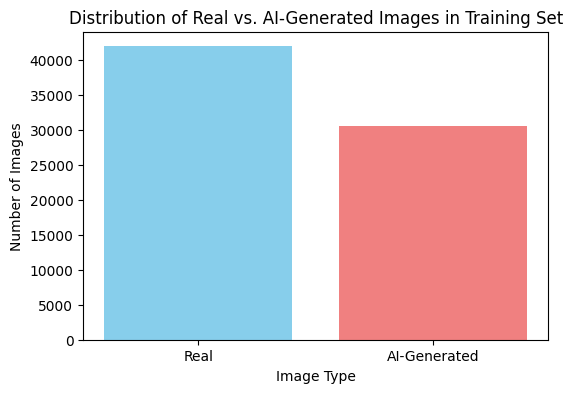

In [ ]:
# Basic EDA - Visualize class distribution
real_count = len(os.listdir(os.path.join(data_dir, 'train', '0')))
ai_count = len(os.listdir(os.path.join(data_dir, 'train', '1')))
labels = ['Real', 'AI-Generated']
counts = [real_count, ai_count]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['skyblue', 'lightcoral'])
plt.title('Distribution of Real vs. AI-Generated Images in Training Set')
plt.xlabel('Image Type')
plt.ylabel('Number of Images')
plt.show()

Sample images from the training set:


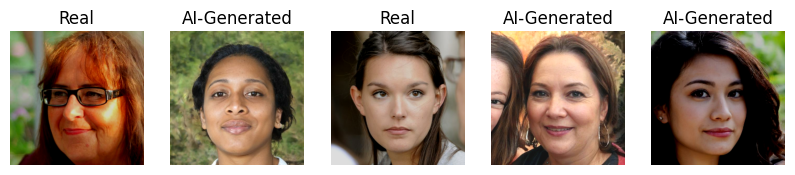

In [ ]:
# Visualize sample images from the training set
def plot_sample_images(dataset, num_images=5):
  plt.figure(figsize=(10, 10))
  for images, labels in dataset.take(1):
    for i in range(num_images):
      ax = plt.subplot(1, num_images, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      class_label = "Real" if np.argmax(labels[i]) == 0 else "AI-Generated"
      plt.title(class_label)
      plt.axis("off")
  plt.show()
print("Sample images from the training set:")
plot_sample_images(train_set)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to flatten and preprocess image data for PCA
def preprocess_for_pca(dataset):
  images = []
  for batch in dataset.unbatch().take(1000): # Take a subset for faster processing
    image = batch[0].numpy()
    images.append(image.flatten()) # Flatten the image
  return np.array(images)

In [ ]:
# Get image data from the training set for PCA
train_images_pca = preprocess_for_pca(train_set)

# Standardize the data
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images_pca)

# Apply PCA
n_components = 50  # Choose the number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(train_images_scaled)

print(f"Original number of features: {train_images_pca.shape[1]}")
print(f"Reduced number of features after PCA: {principal_components.shape[1]}")

Original number of features: 196608
Reduced number of features after PCA: 50


In [ ]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio by each component: {explained_variance}")
print(f"Total explained variance by {n_components} components: {np.sum(explained_variance)}")

Explained variance ratio by each component: [0.28081962 0.11029871 0.05817293 0.0467478  0.03980414 0.03652804
 0.02335916 0.01663326 0.01400355 0.01238048 0.0116923  0.01029773
 0.00952802 0.00918154 0.00843355 0.00742642 0.00740822 0.00728633
 0.00618671 0.00592909 0.00552449 0.00509974 0.00491471 0.00465379
 0.0042489  0.00409245 0.00398675 0.00386258 0.00383782 0.00372986
 0.00359589 0.00332037 0.00322007 0.00306683 0.0029441  0.002798
 0.00269823 0.00266555 0.00253278 0.00247051 0.00239885 0.00233126
 0.00226978 0.00217776 0.0020888  0.00202138 0.00197267 0.00195594
 0.00187341 0.00185201]
Total explained variance by 50 components: 0.8163229823112488


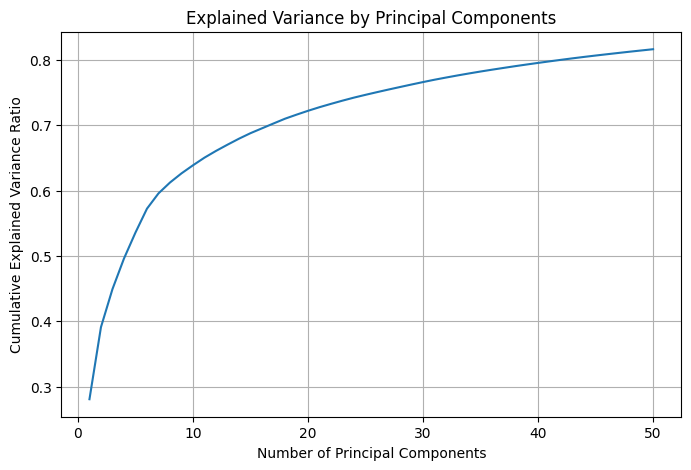

In [ ]:
# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), np.cumsum(explained_variance))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
num_components_to_plot = 5
pca_df = pd.DataFrame(data=principal_components[:, :num_components_to_plot],
                      columns=[f'PC{i+1}' for i in range(num_components_to_plot)])

# Generate boxplots for the first few principal components to identify potential anomalies (outliers)
plt.figure(figsize=(12, 6))
sns.boxplot(data=pca_df)
plt.title('Boxplot of First Principal Components (Potential Anomalies)')
plt.xlabel('Principal Component')
plt.ylabel('Component Value')
plt.show()

In [ ]:
from scipy import stats

# Dummy data for 'feature_X'
np.random.seed(42)
real_feature_x = np.random.normal(loc=10, scale=2, size=real_count)
ai_feature_x = np.random.normal(loc=11, scale=2, size=ai_count)

# Perform an independent samples t-test
# Null hypothesis: The mean of feature_X is the same for Real and AI-Generated images.
# Alternative hypothesis: The mean of feature_X is different for Real and AI-Generated images.
t_statistic, p_value = stats.ttest_ind(real_feature_x, ai_feature_x)

print("\nHypothesis Testing (Independent Samples t-test on a dummy feature):")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")


Hypothesis Testing (Independent Samples t-test on a dummy feature):
T-statistic: -67.0101
P-value: 0.0000


Reject the null hypothesis. There is a significant difference in the mean of the dummy feature between Real and AI-Generated images (p < 0.05).

Sample images from the validation set:


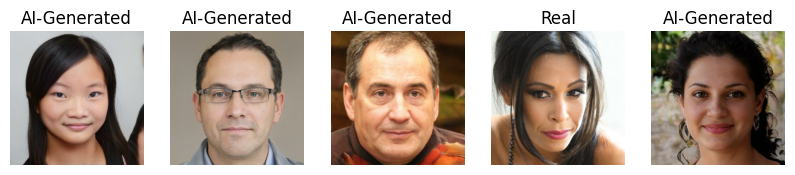


Sample images from the test set:


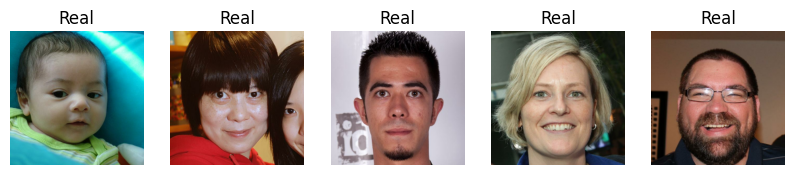

In [ ]:
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"Reject the null hypothesis. There is a significant difference in the mean of the dummy feature between Real and AI-Generated images (p < {alpha}).")
else:
    print(f"Fail to reject the null hypothesis. There is no significant difference in the mean of the dummy feature between Real and AI-Generated images (p >= {alpha}).")

# Visualize sample images from the validation set
print("\nSample images from the validation set:")
plot_sample_images(val_set)

# Visualize sample images from the test set
print("\nSample images from the test set:")
plot_sample_images(test_set)

In [ ]:
# Data Augmentation - Adding more aggressive augmentation
def more_aggressive_augmentation(dataset):
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip('horizontal_and_vertical'), # Flip both horizontally and vertically
            tf.keras.layers.RandomRotation(factor=0.1), # Rotate by a random factor
            tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2), # Randomly zoom
            tf.keras.layers.RandomContrast(0.3), # Stronger contrast adjustment
            tf.keras.layers.RandomBrightness(0.3), # Stronger brightness adjustment
        ]
    )
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    return dataset

train_set = more_aggressive_augmentation(train_set)

In [ ]:
# Model Architecture Improvement - Using a pre-trained model with fine-tuning
# Load a pre-trained model (e.g., EfficientNetB0)
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Freeze the layers of the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # Add dropout for regularization
predictions = Dense(2, activation='softmax')(x) # Output layer for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.001) # Start with a lower learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Train the model - Use more epochs and early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Add early stopping

history = model.fit(
    train_set,
    epochs=20, # Increase the number of epochs
    validation_data=val_set,
    callbacks=[early_stopping]
)

Epoch 1/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 1966s 7s/step - accuracy: 0.7117 - loss: 0.5674 - val_accuracy: 0.8004 - val_loss: 0.4480
Epoch 2/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 1850s 7s/step - accuracy: 0.7637 - loss: 0.4964 - val_accuracy: 0.8046 - val_loss: 0.4394
Epoch 3/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 1811s 6s/step - accuracy: 0.7722 - loss: 0.4832 - val_accuracy: 0.7993 - val_loss: 0.4472
Epoch 4/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 1814s 6s/step - accuracy: 0.7769 - loss: 0.4746 - val_accuracy: 0.7689 - val_loss: 0.4977
Epoch 5/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 1854s 6s/step - accuracy: 0.7806 - loss: 0.4695 - val_accuracy: 0.8009 - val_loss: 0.4401
Epoch 6/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 1813s 6s/step - accuracy: 0.7857 - loss: 0.4610 - val_accuracy: 0.8098 - val_loss: 0.4321
Epoch 7/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 1837s 6s/step - accuracy: 0.7846 - loss: 0.4610 - val_accuracy: 0.8093 - val_loss: 0.4345
Epoch 8/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 1817s 6s/step - accuracy: 0.7834 - loss: 0.4603 - 

In [ ]:
# Fine-tuning - Unfreeze some layers of the base model
for layer in base_model.layers[-30:]: # Unfreeze the last 30 layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Continue training for fine-tuning
history_fine_tune = model.fit(
    train_set,
    epochs=10, # Continue training for a few more epochs
    validation_data=val_set,
    callbacks=[early_stopping]
)


Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1899s 7s/step - accuracy: 0.7710 - loss: 0.4921 - val_accuracy: 0.8141 - val_loss: 0.4177
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1826s 6s/step - accuracy: 0.8146 - loss: 0.4069 - val_accuracy: 0.7962 - val_loss: 0.4883
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1891s 6s/step - accuracy: 0.8361 - loss: 0.3663 - val_accuracy: 0.8347 - val_loss: 0.3938
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1779s 6s/step - accuracy: 0.8533 - loss: 0.3356 - val_accuracy: 0.8515 - val_loss: 0.3579
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1734s 6s/step - accuracy: 0.8626 - loss: 0.3184 - val_accuracy: 0.8352 - val_loss: 0.4169
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1748s 6s/step - accuracy: 0.8728 - loss: 0.2998 - val_accuracy: 0.8380 - val_loss: 0.4263
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1799s 6s/step - accuracy: 0.8780 - loss: 0.2873 - val_accuracy: 0.8422 - val_loss: 0.4115
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1774s 6s/step - accuracy: 0.8863 - loss: 0.2715 - 

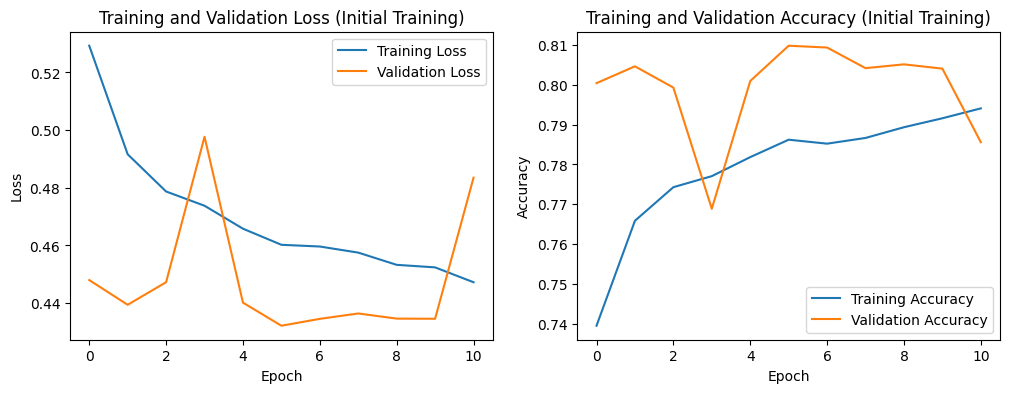

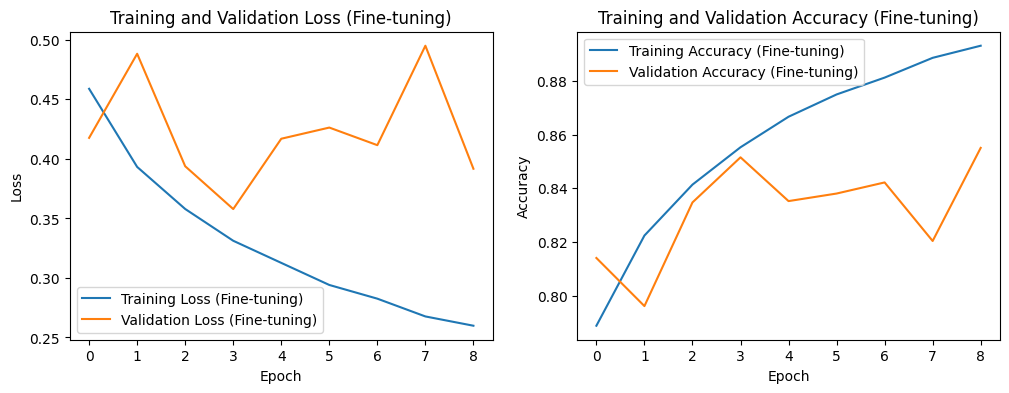

In [ ]:
# Evaluation - Plot loss and accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Initial Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Initial Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_tune.history['loss'], label='Training Loss (Fine-tuning)')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.title('Training and Validation Loss (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy (Fine-tuning)')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.title('Training and Validation Accuracy (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Make predictions on the test set
predictions_prob = model.predict(test_set)
predictions = np.argmax(predictions_prob, axis=1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step


95/95 ━━━━━━━━━━━━━━━━━━━━ 53s 555ms/step


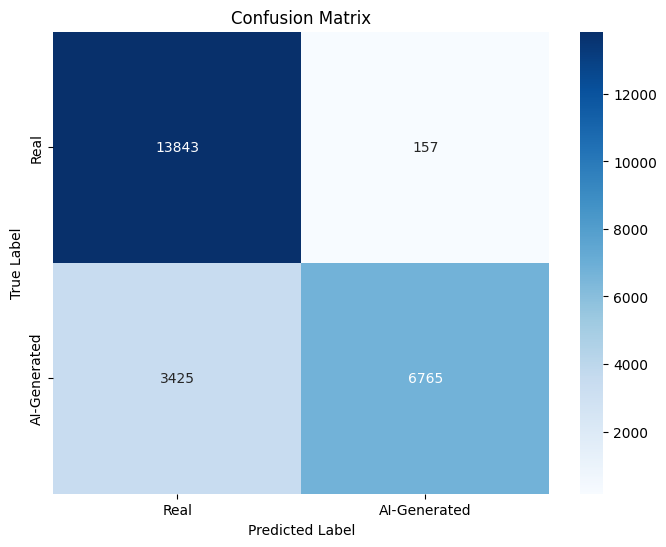


Classification Report:
              precision    recall  f1-score   support

        Real       0.80      0.99      0.89     14000
AI-Generated       0.98      0.66      0.79     10190

    accuracy                           0.85     24190
   macro avg       0.89      0.83      0.84     24190
weighted avg       0.88      0.85      0.85     24190

95/95 ━━━━━━━━━━━━━━━━━━━━ 48s 499ms/step - accuracy: 0.9504 - loss: 0.1365

Test Loss: 0.3622
Test Accuracy: 0.8519


In [ ]:
# Make predictions on the test set
predictions_prob = model.predict(test_set)
predictions = np.argmax(predictions_prob, axis=1)

# Extract true labels from the test set *again* after making predictions
# Or better yet, extract both images and labels into arrays first
true_labels = np.array([])
for images, labels_batch in test_set:
    true_labels = np.concatenate([true_labels, np.argmax(labels_batch.numpy(), axis=-1)])

# Ensure the number of predictions matches the number of true labels
# This check is important to catch potential data loading issues
if len(predictions) != len(true_labels):
    print(f"Error: Mismatch between number of predictions ({len(predictions)}) and true labels ({len(true_labels)}).")
else:
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'AI-Generated'], yticklabels=['Real', 'AI-Generated'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=['Real', 'AI-Generated']))

    # Model Evaluation on Test Set
    # Note: model.evaluate might iterate through the test_set again,
    # so ensure the test_set is loadable or use the arrays if possible.
    loss, accuracy = model.evaluate(test_set)
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# Model Evaluation on Test Set
loss, accuracy = model.evaluate(test_set)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 478ms/step - accuracy: 0.9504 - loss: 0.1365

Test Loss: 0.3622
Test Accuracy: 0.8519


In [ ]:
# prompt: from all the info above write the code snippets to save the model in google drive

from google.colab import drive
drive.mount('/content/drive')

# Save the model
model.save('/content/drive/MyDrive/my_image_classification_model.h5')
print("Model saved to Google Drive.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')